In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## 1. Logistic Regression

In [2]:
def UniGaussian(m,s):
    # generate X~N(0,1)
    S = 1
    while(S>=1):
        U = np.random.uniform(-1,1)
        V = np.random.uniform(-1,1)
        S = U**2 +V**2
    X = U * (-2 * math.log(S)/ S)**0.5
    
    # generate Y~N(m,s)
    Y = s **0.5*X + m
    
    return Y

In [3]:
def DataGeneration(N,mx,vx,my,vy):
    DX =[]
    DY =[]
    for i in range(N):
        x = UniGaussian(mx,vx)
        y = UniGaussian(my,vy)
        DX.append(x)
        DY.append(y)
    return DX,DY

In [4]:
# zero matrix
def zeroM(size):
    M = np.zeros((size, size))
    return M
# LU decomposition A=LU
def LUDecomposition(A):
    n = A.shape[0]
    L = zeroM(n)
    U = A.copy()
    for i in range(n):
        L[i][i] = 1.0
        for j in range(i+1, n):
            scalar = U[j][i]/U[i][i]
            L[j][i] = scalar
            for k in range (n):
                U[j][k] -= scalar* U[i][k]
    return L, U

# find [Y], that [L][Y] = [I]
def FindY(L):
    n = L.shape[0]
    Y = zeroM(n)
    I = np.identity(n)
    # for every column solve Ly = b
    for i in range(n):
        b = I[:, i]
        y = np.zeros_like(b, dtype=np.float64)
        for row in range(n):
            y[row] = b[row]
            for col in range(row):
                y[row] -= L[row][col] * y[col]
            y[row] /= L[row][row]
        
        Y[:, i] = y
    return Y

# find [X], that [Y] = [U][X]
def FindX(Y, U):
    n = U.shape[0]
    X = np.zeros_like(Y)    
    # For every column, solve Ux = y
    for i in range(Y.shape[1]):
        y = Y[:, i]
        x = np.zeros_like(y, dtype=np.float64)
        for row in reversed(range(n)):
            x[row] = y[row]
            for col in range(row + 1, n):
                x[row] -= U[row][col] * x[col]
            x[row] /= U[row][row]
        
        X[:, i] = x
    
    return X

# Find inverse using LU decomposition
# to find A-1, that [A][A-1] = [I]
# step1: using [A] = [L][U]
# step2: find [Y], that [Y] = [U][A-1] => [A][A-1] = [L][U][A-1] = [L][Y] = [I]
# step3: find [X] = [A-1], that [Y] = [U][X]
def FindInverse(A):
    # step1: using [A] = [L][U]
    L, U = LUDecomposition(A)
    # step2: find [Y], that [L][Y] = [I]
    Y = FindY(L)
    # step3: find [X], that [Y] = [U][X]
    Inverse = FindX(Y,U)
    
    return Inverse

In [5]:
def output1(w,Phi,Y):
    # w
    print(f"w:")
    for i in range(w.shape[0]):
        print(f"{w[i, 0]}")
    print("")
    
    # Confusion Matrix
    pred_value = np.dot(Phi,w)
    pred_label = np.where(pred_value> 0.5, 1, 0) 
    
    TP, FN, FP, TN = 0, 0, 0, 0
    N=len(pred_label)//2
    
    for i in range(2*N):
        if(pred_label[i]==0 and i<N):
            TP+=1
        elif(pred_label[i]==0 and i>=N):
            FP+=1
        elif(pred_label[i]==1 and i<N):
            FN+=1
        else:
            TN+=1
            
    print(f"Confusion Matrix:")
    print("{:<20} {:<25} {}".format(' ', 'Prediction Cluster 1', 'Prediction Cluster 2'))
    print("{:<30} {:<25} {}".format('Is Cluster 1', TP, FN))
    print("{:<30} {:<25} {}".format('Is Cluster 2', FP, TN))
    print("")
    
    # Sensitivity and Specifity
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    print("Sensitivity (Successfully predict cluster 1): {:.5f}".format(sensitivity))
    print("Specificity (Successfully predict cluster 2): {:.5f}".format(specificity))
    
    return pred_label

In [6]:
def viz1(DX,DY, Y, pred_gd, pred_nt):
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].scatter(DX[Y == 0], DY[Y == 0], color='red')
    axs[0].scatter(DX[Y == 1], DY[Y == 1], color='blue')
    axs[0].set_title('Ground truth')

    axs[1].scatter(DX[pred_gd == 0], DY[pred_gd == 0], color='red')
    axs[1].scatter(DX[pred_gd == 1], DY[pred_gd == 1], color='blue')
    axs[1].set_title('Gradient descent')
    
    axs[2].scatter(DX[pred_nt == 0], DY[pred_nt == 0], color='red')
    axs[2].scatter(DX[pred_nt == 1], DY[pred_nt == 1], color='blue')
    axs[2].set_title("Newton's method")

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [7]:
# design matrix phi
#|1, x1, y1|
#|1, x2, y2|
#|1, xn, yn|
def phiM(X1,Y1,X2,Y2,N):
    M=[]
    for i in range(N):
        M.append([1,X1[i],Y1[i]])
    for j in range(N):
        M.append([1,X2[j],Y2[j]])
    return np.array(M)

### Steepest gradient descent

### Gradient
$$\frac{\partial J}{\partial w_j} = \sum_i \phi_{ij} (y_i - \frac{1}{1+e^{-w^T\Phi_i}})$$
$$ \frac{\partial J}{\partial w}= \Phi^T [y - \frac{1}{1+e^{-w^T\Phi}}]$$
<br>
$$w^{(n+1)}=w^{(n)} + \nabla f(x_n)$$

In [8]:
def logistic(X):
    return 1/(1+ np.exp(-X))

In [9]:
def Gradient(w,Phi,Y):
    predY = logistic(np.dot(Phi,w))
    dJ = np.dot(Phi.T,(Y-predY))
    return dJ

### Newtons method
$$Hf(x_n) = \Phi^T*D*\Phi$$
$$D_{ii} =\frac{e^{-w_i^T\Phi_{i,1}}}{(1+e^{-w_i^T\Phi_{i,1}})^2}, D_{ij} =0 $$
<br>
$$w^{(n+1)}=w^{(n)} + H^{-1}f(x_n) * \nabla f(x_n)$$

In [10]:
def Hessian(w,Phi,N):
    predY = logistic(np.dot(Phi,w))
    dia = (1-predY)*predY
    D = np.diag(dia.flatten())    
    H = np.dot(np.dot(Phi.T, D), Phi) 
    return H

Gradient Descent:

w:
-1.9333984922272742
0.6469281176733708
0.33135389846044994

Confusion Matrix:
                     Prediction Cluster 1      Prediction Cluster 2
Is Cluster 1                   45                        5
Is Cluster 2                   17                        33

Sensitivity (Successfully predict cluster 1): 0.90000
Specificity (Successfully predict cluster 2): 0.66000
-----------------------------------------------------------------
Newton's method:

w:
-1.7742856946908898
0.5846512764251602
0.3013748089671371

Confusion Matrix:
                     Prediction Cluster 1      Prediction Cluster 2
Is Cluster 1                   45                        5
Is Cluster 2                   17                        33

Sensitivity (Successfully predict cluster 1): 0.90000
Specificity (Successfully predict cluster 2): 0.66000


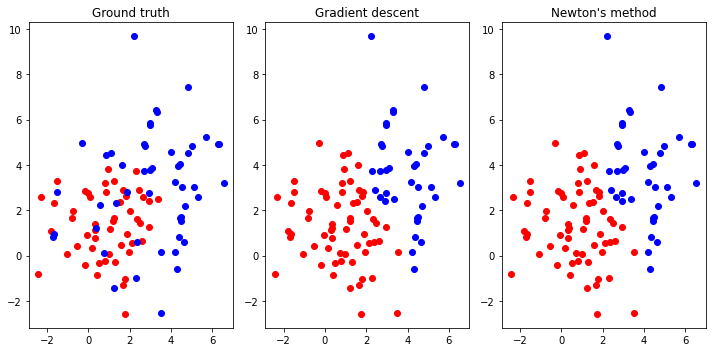

In [26]:
lr = 1e-2
N = 50
mx1 = my1 = 1
mx2 = my2 = 10
vx1 = vy1 = 2
vx2 = vy2 = 2

mx1 = my1 = 1
mx2 = my2 = 3
vx1 = vy1 = 2
vx2 = vy2 = 4

for i in range(N):
    D1X,D1Y = DataGeneration(N,mx1,vx1,my1,vy1)
    D2X,D2Y = DataGeneration(N,mx2,vx2,my2,vy2)
    
Phi = phiM(D1X,D1Y, D2X,D2Y,N) # shape=2N*3
Y1 = np.zeros((N, 1)) #ground truth label
Y2 = np.ones((N, 1))
Y = np.vstack((Y1, Y2))

# Gradient descent
w_gd = np.zeros((3,1))
threshold_gd = 1e-3
while True:
    last_w = w_gd
    dJ = Gradient(w_gd,Phi,Y)
    w_gd = last_w + lr* dJ
    
    d_w = abs(sum(w_gd)-sum(last_w))
    if d_w < threshold_gd:
        break

print(f"Gradient Descent:\n")
pred_gd = output1(w_gd,Phi,Y)
print("-----------------------------------------------------------------")

# Newton's method
w_nt = np.zeros((3,1))
threshold_nt = 1e-3
while True:
    last_w = w_nt
    dJ = Gradient(w_nt,Phi,Y)
    H = Hessian(w_nt,Phi,2*N)
    if np.linalg.det(H) != 0:
        H_inv = FindInverse(H)
        w_nt = last_w + lr* np.dot(H_inv,dJ)
    else:
        w_nt = last_w + lr* dJ
    d_w = abs(sum(w_nt)-sum(last_w))
    if d_w < threshold_nt:
        break

print(f"Newton's method:\n")
pred_nt = output1(w_nt,Phi,Y)

DX= np.concatenate((D1X, D2X))
DY= np.concatenate((D1Y, D2Y))
viz1(DX,DY, Y.flatten(), pred_gd.flatten(), pred_nt.flatten())

## 2. EM algorithm

In [12]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [13]:
# Load Data
def LoadData(img_path, label_path):
    # Load Images
    with open(img_path, 'rb') as f:
        # header: magic_num(4), img_num(4), img_row(4), img_col(4)
        magic_num = f.read(4)
        data_num = int.from_bytes(f.read(4), byteorder='big')    
        img_row = int.from_bytes(f.read(4), byteorder='big')      
        img_col = int.from_bytes(f.read(4), byteorder='big')     
        
        # read the bit of image
        imgs = np.zeros((data_num, img_row * img_col), dtype=np.uint8) 
        desc = "Loading Images"
        for i in tqdm(range(data_num), desc=desc):
            img = np.zeros((img_row*img_col), np.uint8) # only 0~255
            for r in range(img_row):
                for c in range(img_col):
                    img[r*img_row + c] = int.from_bytes(f.read(1), byteorder='big')//128 # binning to 2 bins
            imgs[i] = img
            
    # Load Labels
    with open(label_path, 'rb') as f:
        # header: magic_num(4), label_num(4)
        magic_num = f.read(4)
        data_num = int.from_bytes(f.read(4), byteorder='big')      
        
        # read the labels
        labels = []
        desc = "Loading Labels"
        for i in tqdm(range(data_num), desc=desc):
            labels.append(int.from_bytes(f.read(1), byteorder='big')) 
            
    return data_num, img_row, imgs, labels          
                   

In [14]:
def PrintImg(p,img_size,cluster_label,flag):
    for d in range(10): 
        if(flag==1):
            print(f"Labeled ", end="")
        print(f"class{d}:")
        index = np.where(cluster_label== d)[0][0] 
        for r in range(img_size):
            for c in range(img_size):
                print("#" if p[index][r*img_size + c]>0.5 else "-", end=" ")
            print("")
        print("")

In [15]:
def assingnlabel(labels,w, num):
    label_of_cluster = np.zeros(10)  
    result = np.zeros((10, 10)) 
    cluster_of_img = np.zeros(num, dtype=int)
    label_of_img = np.zeros(num,dtype=int)
    
    for img in range(num):
        label = labels[img]
        cluster = np.argmax(w[img])
        result[label][cluster] += 1
        cluster_of_img[img] = cluster
    
    for _ in range(10): 
        label, cluster = np.unravel_index(np.argmax(result), result.shape)
        label_of_cluster[cluster] = label
        result[label, :] = -1
        result[:, cluster] = -1
    for img in range(num):
        label_of_img[img] = label_of_cluster[cluster_of_img[img]]
    return label_of_cluster, label_of_img

In [16]:
def output(label, num, label_of_img,iteration):
    error = num
    for d in range(10):    
        TP, FN, FP, TN = 0, 0, 0, 0
        for img in range(num):
            if(label_of_img[img]==d and label[img]==d):
                TP+=1
            elif(label_of_img[img]==d and label[img]!=d):
                FP+=1
            elif(label_of_img[img]!=d and label[img]==d):
                FN+=1
            else:
                TN+=1
        
        error-=TP
        print(f"Confusion Matrix {d}:")
        print("{:<20} {:<25} {}".format(' ', f'Predict number {d}', f'Predict not number {d}'))
        print("{:<30} {:<25} {}".format(f'Is number {d}', TP, FN))
        print("{:<30} {:<25} {}".format(f'Is not number {d}', FP, TN))
        print("")

        # Sensitivity and Specifity
        sensitivity = TP/(TP+FN)
        specificity = TN/(TN+FP)
        print(f"Sensitivity (Successfully predict number {d}):"," {:.5f}".format(sensitivity))
        print(f"Specificity (Successfully predict number {d}):","{:.5f}".format(specificity))
        print("--------------------------------------------------------")
    

    print(f"Total iteration to converge: {iteration+1}")
    print(f"Total error rate: {error/num}")

|E step| |
|--|--|
||$$P(class=d, img | \theta) = \lambda_d \prod_{px, x=img[px]}^{28*28} (P_{d,px})^x(1-P_{d,px})^{1-x}$$|
||$$w_{img,d} = \frac{P(class=d, img | \theta)}{\sum_{i=0}^{9}P(class=i, img | \theta)}$$| 

|M step| |
|--|--|
||$$\lambda_d = \frac{\sum_{img}^{\#img}w_{img,d}}{\#img}$$|
||$$ p_{d,px} = \frac{\sum_{img}^{\#img}w_{img,d}*img[px]}{\sum_{img}^{\#img}w_{img,d}}$$| 

In [17]:
def EMalgorithm(num, img_size, imgs, labels):
#     initial parameter Θ = {λ, p}
#     λ = {λ0, λ2, λ3, ..., λ9}
#     p = |p0,0     p1,0     ... p9,0    |
#         |...                           |
#         |p0,28*28 p1,28*28 ... p9,28*28|

    lambda_ = np.full(10, 0.1)
    p = np.random.uniform(0.05,0.95, (10, 28 * 28))
    _imgs = 1-imgs
    cluster_label = np.arange(10)
    for iteration in range(100):
        _p = 1-p
        # E step: 
        # calculate w{img,d} =P(class=d, img|Θ)/sum_i P(class=i, img|Θ)
        w = np.zeros((num,10))
        for img in tqdm(range(num), desc="E step"):
            for d in range(10):
                w[img][d] = lambda_[d]* np.prod(np.power(p[d], imgs[img]))* np.prod(np.power(_p[d], _imgs[img]))
            w[img] = w[img]/sum(w[img])

        # M step
        new_lambda = np.zeros(10)
        new_p =  np.zeros((10, 28 * 28))
        for d in tqdm(range(10), desc="M step"):
            sum_w = np.sum(w[:, d])
            new_lambda[d] = sum_w/num
            for px in range(28 * 28):    
                new_p[d][px] = np.dot(imgs[:,px],w[:,d])/sum_w
                if new_p[d][px]==0:
                    new_p[d][px]=1e-5

        diff = np.sum(np.abs(p-new_p))
        p_conv = diff<20 
        p = new_p
        lambda_ = new_lambda
        
        PrintImg(p,img_size,cluster_label,0)
        print(f"No. of Iteration: {iteration+1}, Difference: {diff}",flush=True)
        if p_conv :
            break
            
    print("--------------------------------------------------------")
    cluster_label, img_pred = assingnlabel(labels,w, num)
    PrintImg(p,img_size,cluster_label,1)
    output(labels, num, img_pred,iteration)

    

In [18]:
img_path = "./MNIST/train-images.idx3-ubyte_"
label_path = "MNIST/train-labels.idx1-ubyte_"

num, img_size, imgs, labels = LoadData(img_path, label_path)
EMalgorithm(num, img_size, imgs, labels)

M step: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.71it/s]


class0:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - # # # # - - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # # - - - - - - - - - 
- - - - - - - - # # # # # # # # # # # - - - - - - - - - 
- - - - - - - - # # # - - - - - # # # - - - - - - - - - 
- - - - - - - - - - - - - - - - # # # - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - # # # # # - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # # - - - - - - - - - 
- - - - - - - - - - # # - - - # # # # # - - - - - - - - 
- - - - - - - - - - - - - - - - - # # # - - - - - - - - 
- - - - - - - - - - - - - - - - - - # # - - - - - - - - 
- - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - # # # - - - - - - - - - - - - - 
- - - - - - - - - - # # # # - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - # - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - # # # - - - - - - - - - 
- - - - - - - - - - - - - - # # # # - - - - - - - - - - 
- - - - - - - - - - - - - # # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - - - - - # - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - - - - #

M step: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.80it/s]


class0:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # # - - - - - - - - - 
- - - - - - - - # # # # # # # # # # # - - - - - - - - - 
- - - - - - - - - - - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - # - - - - - - - - - - 
- - - - - - - - - - - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - # # # # - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # # - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # # - - - - - - - - 
- - - - - - - - - - - - - - - - - - # # # - - - - - - - 
- - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - # # - - - - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - # # # # - - - - # # - - - - - - - - - 
- - - - - - - - - - # - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - #

M step: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.75it/s]


class0:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - # - - - - - - - - - - - 
- - - - - - - - - - - - - - # # # - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # # - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # # - - - - - - - - 
- - - - - - - - - - - - - - - - - - # # - - - - - - - - 
- - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - # # # - - - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - # # # # - - - # # # - - - - - - - - - 
- - - - - - - - - # # - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - # # # - - - - - - - - - 
- - - - - - - - - - - - - - - - # # # - - - - - - - - - 
- - - - - - - - - - - - - - - # # # # - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - #

M step: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.77it/s]


class0:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # - - - - - - - - - - 
- - - - - - - - # # # # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - # # # - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # # - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # # - - - - - - - - 
- - - - - - - - - - - - - - - - - - # # - - - - - - - - 
- - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - # # # - - - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # # - - - - - - - - - 
- - - - - - - - - # # # # - - - # # # - - - - - - - - - 
- - - - - - - - - # # # - - - - - # # - - - - - - - - - 
- - - - - - - - - # - - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - # # # - - - - - - - - - 
- - - - - - - - - - - - - - - - # # # - - - - - - - - - 
- - - - - - - - - - - - - - - # # # # - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - #

M step: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


class0:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # - - - - - - - - - - 
- - - - - - - - # # # # # # # # # # - - - - - - - - - - 
- - - - - - - - - # - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - - - # # - - - - - - - - 
- - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - # # # # # # # # - - - - - - - 
- - - - - - - - - - - # # # # # # # # # # # - - - - - - 
- - - - - - - - - - # # # # # # # # # # # # - - - - - - 
- - - - - - - - - - # # # # - - - - - # # - - - - - - - 
- - - - - - - - - # # # # - - - - - - - - - - - - - - - 
- - - - - - - - - # # # - - - - - - - - - - - - - - - - 
- - - - - - - - - # # # # - - - - # - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - -

M step: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


class0:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # - - - - - - - - - - 
- - - - - - - - # # # # # # # # # # - - - - - - - - - - 
- - - - - - - - - # - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - # - - - - - - - - 
- - - - - - - - - - - -

- - - - - - - # # # # # # # # # # - - - - - - - - - - - 
- - - - - - - - # # # # # # # # - - - - - - - - - - - - 
- - - - - - - - - - # # # - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 

class6:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - # # # # # # # # - - - - - - - 
- - - - - - - - - - - # # # # # # # # # # - - - - - - - 
- - - - - - - - - - # # # # # # # # # # # - - - - - - - 
- - - - - - - - - - # # # # - - - - - # # - - - - - - - 
- - - - - - - - - - # 

M step: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.74it/s]


class0:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # - - - - - - - - - - 
- - - - - - - - # # # # # # # # # # - - - - - - - - - - 
- - - - - - - - - # - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - # # - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - # - - - - - - - - 
- - - - - - - - - - - -

- - - - - - - - - - - - - - - - - - - - - - - - - - - - 

class6:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - # # # # # # # # - - - - - - - 
- - - - - - - - - - - # # # # # # # # # # - - - - - - - 
- - - - - - - - - - # # # # # # - # # # # - - - - - - - 
- - - - - - - - - - # # # - - - - - - # - - - - - - - - 
- - - - - - - - - - # # # - - - - - - # - - - - - - - - 
- - - - - - - - - - # # - - - - - - # - - - - - - - - - 
- - - - - - - - - - # # # - - - # # - - - - - - - - - - 
- - - - - - - - - - # # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - - - 

M step: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


class0:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # - - - - - - - - - - 
- - - - - - - - # # # # # # # # # # - - - - - - - - - - 
- - - - - - - - - # - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - # - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - # - - - - - - - - 
- - - - - - - - - - - -

- - - - - - - - - - - - - - - - - # # # - - - - - - - - 
- - - - - - - - - - - - - - - - - # # # - - - - - - - - 
- - - - - - - - - - - - - - - - - # # # - - - - - - - - 
- - - - - - - - - - - - - - - - # # # - - - - - - - - - 
- - - - - - - - - - - - - - - # # # # - - - - - - - - - 
- - - - - - - # # # - - - - # # # # - - - - - - - - - - 
- - - - - - - # # # # # # # # # # - - - - - - - - - - - 
- - - - - - - - # # # # # # # # - - - - - - - - - - - - 
- - - - - - - - - # # # # - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 

class6:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - 

M step: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


class0:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - # # # # # # - - - - - - - - - - - 
- - - - - - - - - # # # # # # # # # - - - - - - - - - - 
- - - - - - - - # # # # # # # # # # - - - - - - - - - - 
- - - - - - - - - # - - - - - - # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - # # # # # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - # - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - # - - - - - - - - 
- - - - - - - - - - - -

- - - - - - - - # # - - - - # # # # - - - - - - - - - - 
- - - - - - - # # # # # # # # # # - - - - - - - - - - - 
- - - - - - - - # # # # # # # # - - - - - - - - - - - - 
- - - - - - - - - # # # # - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 

class6:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - # # # # # # # - - - - - - - - 
- - - - - - - - - - - # # # # # # # # # # - - - - - - - 
- - - - - - - - - - # # # # # - - - # # # - - - - - - - 
- - - - - - - - - - # 

- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - - # # # # # # - - - - - - - - - 
- - - - - - - - - - - - # # # # # # # # - - - - - - - - 
- - - - - - - - - - - - - - - - # # # # - - - - - - - - 
- - - - - - - - - - - - - - - - - - # # - - - - - - - - 
- - - - - - - - - - - - - - - - - - # # # - - - - - - - 
- - - - - - - - - - - - - - - - - - # # - - - - - - - - 
- - - - - - - - - - - - - - - - - - # # - - - - - - - - 
- - - - - - - - - - - - - - - - - # # # - - - - - - - - 
- - - - - - - - - - - - - - - - - # # # - - - - - - - - 
- - - - - - - - - - - - - - - # # # # - - - - - - - - - 
- - - - - - - - - - - - # # # # # # # - - - - - - - - - 
- - - - - - - - - # # # # # # # # # # - - - - - - - - - 
- - - - - - - # # # # # # # # # # # # - - - - - - - - - 
- - - - - - # # # # # # # # # # # # # - - - - - - - - - 
- - - - - - # # # # # # # # # #

- - - - - - - - - - - - - - - - # # # - - - - - - - - - 
- - - - - - - - - - - - - - - # # # # - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # # - - - - - - - - - - 
- - - - - - - - - - - - - - - # # - - - - - - - - - - - 
- - - - - - - - - - - - - - # # # - - - - - - - - - - - 
- - - - - - - - - - - - - - # # # - - - - - - - - - - - 
- - - - - - - - - - - - - - # # - - - - - - - - - - - - 
- - - - - - - - - - - - - # # # - - - - - - - - - - - - 
- - - - - - - - - - - - - # # # - - - - - - - - - - - - 
- - - - - - - - - - - - - # # - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 

Labeled class8:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - - - - - - - - - - - - - - - - - - - - - - 
- - - - - - - 